In [1]:
from ipywidgets import widgets, interact, Button, HBox, VBox
from IPython.display import display

def create_simulation_parameters_box():
    #Start with an empty list for the simulations parameter box
    simulation_parameters_box = []
    
    #Stock price
    simulation_parameters_box.append(widgets.IntSlider(
    value=50,
    min=1,
    max=100,
    step=1,
    description='Stock Price:',
    readout_format='.1f',
    ))
    
    #Volatility (sigma) in the binomial tree
    simulation_parameters_box.append(widgets.FloatSlider(
    value=.08,
    min=.01,
    max=.80,
    step=.01,
    description='Volatility:',
    readout_format='.1%',
    ))
    
    #Risk-free rate
    simulation_parameters_box.append(widgets.FloatSlider(
    value=.04,
    min=.01,
    max=.30,
    step=.01,
    description='Risk-free Rate:',
    readout_format='.1%',
    ))
    
    #Number of time steps
    simulation_parameters_box.append(widgets.IntSlider(
    value=4,
    min=1,
    max=12,
    step=1,
    description='Number of Periods:',
    readout_format='.0f',
    ))
    
    #Time increment
    simulation_parameters_box.append(widgets.Dropdown(
    options=['Trading Day', 'Month', 'Quarter', 'Year'],
    value='Month',
    description='Time Increment:'))
    
    #Turn the list to a vertical box
    simulation_parameters_box = VBox(simulation_parameters_box)
    return simulation_parameters_box
simulation_parameters_box = create_simulation_parameters_box()
display(simulation_parameters_box)

In [2]:
simulation_parameters_box.close()

In [3]:
def create_option_parameters_box():
    #Start with an empty list for the option parameter box
    option_parameters_box = []
    
    #Strike price
    option_parameters_box.append(widgets.IntSlider(
    value=50,
    min=1,
    max=100,
    step=1,
    description='Strike Price:',
    readout_format='.1f',
    ))
    
    #Option Type
    option_parameters_box.append(widgets.Dropdown(
    options=['Call', 'Put'],
    value='Call',
    description='Option Type:'))
    
    #Either buying the option or selling the option
    option_parameters_box.append(widgets.Dropdown(
    options=['Long', 'Short'],
    value='Long',
    description='Side:'))
    
    #Turn the list to a vertical box
    option_parameters_box = VBox(option_parameters_box)

    return option_parameters_box
option_parameters_box = create_option_parameters_box()
display(option_parameters_box)

In [4]:
option_parameters_box.close()

In [5]:
def create_widgets():
    #Create the two vertical boxes
    simulation_parameters_box = create_simulation_parameters_box()
    option_parameters_box = create_option_parameters_box()
    
    #Put them together with a horizontal box
    return HBox([simulation_parameters_box, option_parameters_box])
widget_box = create_widgets()
display(widget_box)

In [6]:
#Build a function for valuation
#First fill with code to ensure that the connections work
from ipywidgets import interactive_output

def valuation(S, sigma, rf, T, T_increment, X1, O1, Side1):
    print(S, sigma)
output_object = interactive_output(valuation,{"S":widget_box.children[0].children[0],
                                             "sigma":widget_box.children[0].children[1],
                                             "rf":widget_box.children[0].children[2],
                                             "T":widget_box.children[0].children[3],
                                             "T_increment":widget_box.children[0].children[4],
                                             "X1": widget_box.children[1].children[0],
                                             "O1": widget_box.children[1].children[1],
                                             "Side1": widget_box.children[1].children[2]})
display(VBox([widget_box, output_object]))

In [7]:
widget_box.close()

In [8]:
import numpy as np

#First, bring back the function to build out the binomial tree paths for a stock
S = 50
sigma = .08
rf = .04
T = 4
T_increment = 1/12

#Recall the function to create the nodes
def create_nodes(S, T, sigma, T_increment):
    up = np.exp(sigma * (T_increment ** .5))
    down = 1/up
    
    node_levels = []
    for t in range(T+1):
        nodes = [S * (up ** k) * (down ** (t-k))  for k in range(t+1)]
        nodes = nodes[::-1]
        node_levels.append(nodes)
    return node_levels
node_levels = create_nodes(S, T, sigma, T_increment)
print(node_levels)

[[50.0], [51.16813710710068, 48.85853074477225], [52.36356510022107, 50.00000000000001, 47.7431205307571], [53.58692156929406, 51.168137107100684, 48.85853074477225, 46.65317444606726], [54.83885900010178, 52.36356510022107, 50.000000000000014, 47.74312053075711, 45.58811116028801]]


In [9]:
#Bring back the call and put options formulas with backward induction
def compute_up_probability(rf, T_increment, sigma):
    r_period = np.exp(sigma * (T_increment ** .5))
    rf_period = np.exp(rf * T_increment)
    up = r_period
    down = 1/r_period
    return (rf_period - down) /(up-down)

def call_value(level, strike_price):
    level = np.where(level-strike_price < 0, 0, level-strike_price)
    return level

def put_value(level, strike_price):
    level = np.where(strike_price - level < 0, 0, strike_price- level)
    return level

def backward_induction_node_level(level, sigma, rf, T_increment):
    p_up = compute_up_probability(rf, T_increment, sigma)
    p_down = 1-p_up
    next_level = []
    for i in range(len(level)-1):
        value = p_up * level[i+1] + p_down * level[i]
        value = value / np.exp(rf * T_increment)
        next_level.append(value)
    next_level = np.array(next_level).round(2)
    return next_level

def backward_induction(node_levels, strike_price, sigma, rf, T_increment, option_valuation_function):
    opt_values = []
    level = node_levels[-1]
    level = np.array(level)
    level = option_valuation_function(level, strike_price)
    opt_values.append(level)
    for level in node_levels[::-1][1:]:
        opt_values.append(backward_induction_node_level(opt_values[-1], sigma, rf, T_increment))
    opt_values = opt_values[::-1]
    return opt_values

call_strike = 100
put_strike = 100

call_opt_values = backward_induction(node_levels, call_strike, sigma, rf, T_increment, call_value)
put_opt_values = backward_induction(node_levels, put_strike, sigma, rf, T_increment, put_value)

print(call_opt_values)
print(put_opt_values)

[array([0.]), array([0., 0.]), array([0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
[array([49.89]), array([48.77, 51.04]), array([47.61, 49.95, 52.18]), array([46.41, 48.81, 51.11, 53.3 ]), array([45.161141  , 47.6364349 , 50.        , 52.25687947, 54.41188884])]


Stock Values


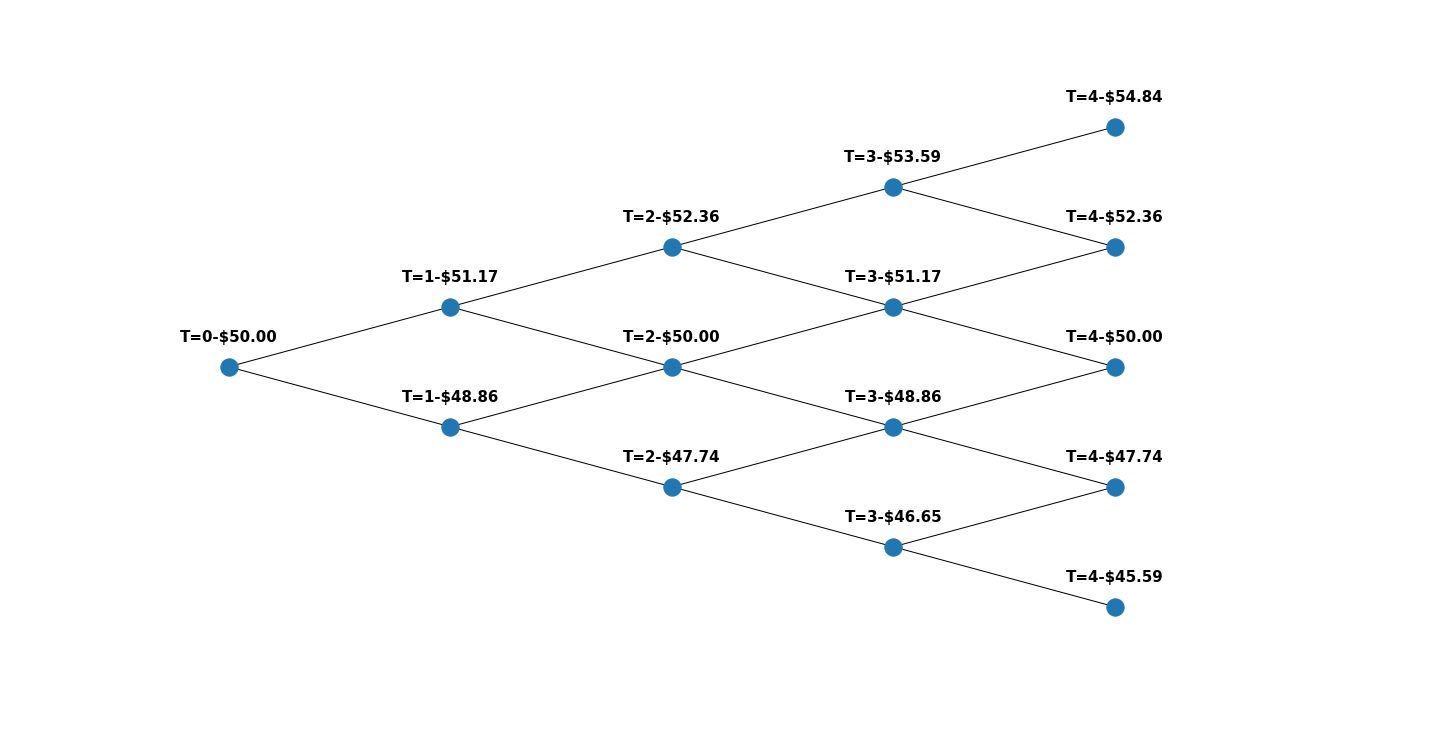

Call Option Values


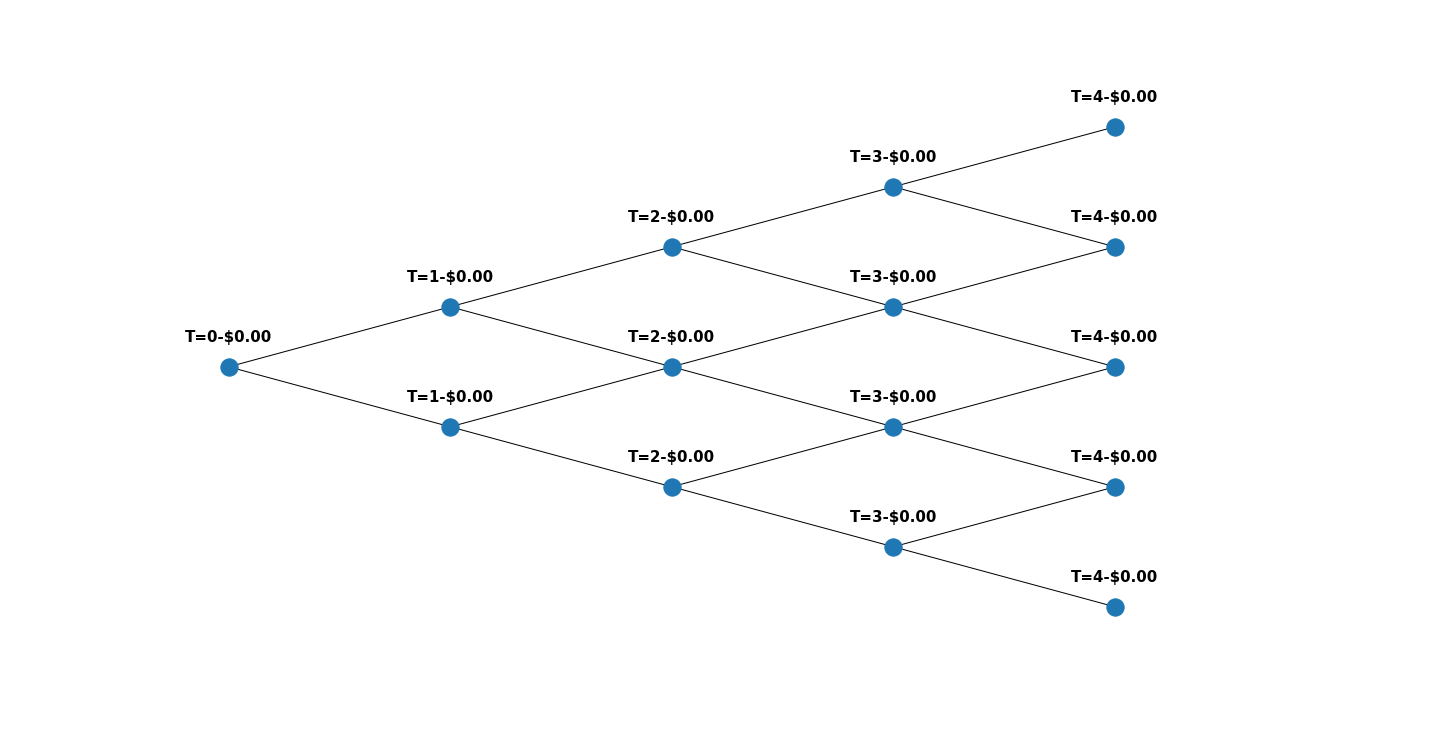

Put Option Values


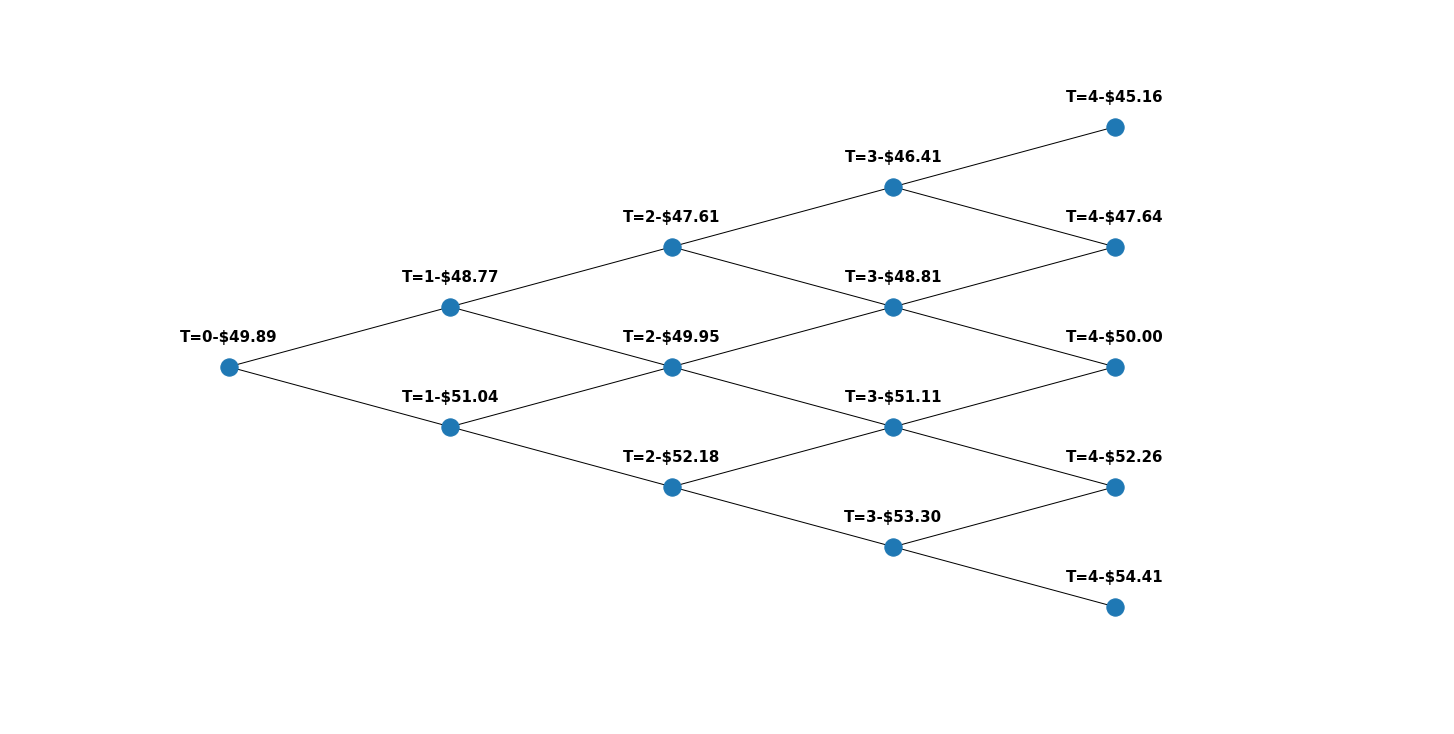

In [10]:
#Bring back the functions for node labels
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

def convert_nodes_to_labels(node_levels):
    node_labels = []
    for t in range(len(node_levels)):
        nodes = ["T={}-${:.2f}".format(t, x) for x in node_levels[t]]
        node_labels.append(nodes)
    return node_labels

def create_node_positions(node_levels):
    pos_dictionary = {}
    
    for i in range(len(node_levels)):
        y_positions = [i/2 - x for x in range(i+1)]
        for i2 in range(len(node_levels[i])):
            pos_dictionary[node_levels[i][i2]] = (i/2, y_positions[i2])
    return pos_dictionary

def draw_binary_tree(node_levels, pos_dictionary, node_labels):
    G = nx.Graph()
    draw_nodes_edges(G, node_levels)
    nx.draw(G, pos=pos_dictionary, with_labels=False, font_weight='bold', font_size=15)
    #The function returns label positions now
    node_label_dictionary, label_positions = build_label_dictionary(node_levels, node_labels, pos_dictionary)
    #Change the last argument to be label positions
    draw_node_labels(G, node_label_dictionary, label_positions)
    plt.xlim([-.5,.25+.5*len(node_levels)])
    plt.ylim([-.5-.5*len(node_levels),.5+.5*len(node_levels)])
    plt.show()

def draw_nodes_edges(G, node_levels):
    G.add_nodes_from(node_levels[0])
    for i in range(len(node_levels)-1):
        G.add_nodes_from(node_levels[i+1])
        G.add_edge(node_levels[i][0], node_levels[i+1][0])
        G.add_edge(node_levels[i][-1], node_levels[i+1][-1])
        for i2 in range(len(node_levels[i+1])-2):
            G.add_edge(node_levels[i][i2], node_levels[i+1][i2+1])
            G.add_edge(node_levels[i][i2+1], node_levels[i+1][i2+1])

def build_label_dictionary(node_levels, node_labels, pos_dictionary):
    node_label_dictionary = {}
    label_positions = {}
    for i1 in range(len(node_levels)):
        for i2 in range(len(node_levels[i1])):
            node_label_dictionary[node_levels[i1][i2]] = node_labels[i1][i2]
            
            #Get the position
            key = node_levels[i1][i2]
            pos = pos_dictionary[key]
            label_positions[key] = (pos[0], pos[1]+.25)
    return node_label_dictionary, label_positions

def draw_node_labels(G, node_label_dictionary, label_positions):
    nx.draw_networkx_labels(G,label_positions, node_label_dictionary, font_weight='bold', font_size=15)


node_levels = convert_nodes_to_labels(node_levels)
call_opt_labels = convert_nodes_to_labels(call_opt_values)
put_opt_labels = convert_nodes_to_labels(put_opt_values)

pos_dictionary = create_node_positions(node_levels)
print("Stock Values")
draw_binary_tree(node_levels, pos_dictionary,node_levels)
print("Call Option Values")
draw_binary_tree(node_levels, pos_dictionary,call_opt_labels)
print("Put Option Values")
draw_binary_tree(node_levels, pos_dictionary,put_opt_labels)

In [11]:
from ipywidgets import interactive_output

def valuation(S, sigma, rf, T, T_increment, X1, O1, Side1):
    #Set t_increment based on the qualitative choice
    if T_increment == "Trading Day":
        T_increment = 1/252
    elif T_increment == "Month":
        T_increment = 1/12
    elif T_increment == "Quarter":
        T_increment = 1/4
    elif T_increment == "Year":
        T_increment = 1
    else:
        assert False
    node_levels = create_nodes(S, T, sigma, T_increment)
    
    #Put in the strike price, and chose the option formula based on the input
    if O1 == "Call":
        opt_formula = call_value
    elif O1 == "Put":
        opt_formula = put_value
        
    opt_values = backward_induction(node_levels, X1, sigma, rf, T_increment, opt_formula)
    
    #If the side is negative flip the signs
    if Side1 == "Long":
        pass
    elif Side1 == "Short":
        opt_values = [-x for x in opt_values]
    else:
        assert False
    
    node_levels = convert_nodes_to_labels(node_levels)
    opt_labels = convert_nodes_to_labels(opt_values)
    
    pos_dictionary = create_node_positions(node_levels)
    print("Stock Values")
    draw_binary_tree(node_levels, pos_dictionary,node_levels)
    print("Option Combination Values")
    draw_binary_tree(node_levels, pos_dictionary,opt_labels)

widget_box = create_widgets()
output_object = interactive_output(valuation,{"S":widget_box.children[0].children[0],
                                             "sigma":widget_box.children[0].children[1],
                                             "rf":widget_box.children[0].children[2],
                                             "T":widget_box.children[0].children[3],
                                             "T_increment":widget_box.children[0].children[4],
                                             "X1": widget_box.children[1].children[0],
                                             "O1": widget_box.children[1].children[1],
                                             "Side1": widget_box.children[1].children[2]})
display(VBox([widget_box, output_object]))

In [12]:
#We can expand this to allow for combinations of options too!
widget_box.close()

#Update the widget box
def create_widgets():
    #Create the two vertical boxes
    simulation_parameters_box = create_simulation_parameters_box()
    option_parameters_box1 = create_option_parameters_box()
    option_parameters_box2 = create_option_parameters_box()
    
    #Put them together with a horizontal box
    return HBox([simulation_parameters_box, option_parameters_box1, option_parameters_box2])
widget_box = create_widgets()
display(widget_box)

In [13]:
widget_box.close()

def valuation(S, sigma, rf, T, T_increment, X1, O1, Side1,
             X2, O2, Side2):
    #Set t_increment based on the qualitative choice
    if T_increment == "Trading Day":
        T_increment = 1/252
    elif T_increment == "Month":
        T_increment = 1/12
    elif T_increment == "Quarter":
        T_increment = 1/4
    elif T_increment == "Year":
        T_increment = 1
    else:
        assert False
    node_levels = create_nodes(S, T, sigma, T_increment)
    
    #Put in the strike price, and chose the option formula based on the input
    if O1 == "Call":
        opt_formula1 = call_value
    elif O1 == "Put":
        opt_formula1 = put_value
        
    if O2 == "Call":
        opt_formula2 = call_value
    elif O2 == "Put":
        opt_formula2 = put_value
        
    opt_values1 = backward_induction(node_levels, X1, sigma, rf, T_increment, opt_formula1)
    opt_values2 = backward_induction(node_levels, X2, sigma, rf, T_increment, opt_formula2)
    
    if Side1 == "Long":
        pass
    elif Side1 == "Short":
        opt_values1 = [-x for x in opt_values1]
    else:
        assert False
        
    if Side2 == "Long":
        pass
    elif Side2 == "Short":
        opt_values2 = [-x for x in opt_values2]
    else:
        assert False
        
    opt_values = [x+y for x,y in zip(opt_values1, opt_values2)]
    
    node_levels = convert_nodes_to_labels(node_levels)
    opt_labels = convert_nodes_to_labels(opt_values)
    
    pos_dictionary = create_node_positions(node_levels)
    print("Stock Values")
    draw_binary_tree(node_levels, pos_dictionary,node_levels)
    print("Option Combination Values")
    draw_binary_tree(node_levels, pos_dictionary,opt_labels)
    
    
widget_box = create_widgets()
output_object = interactive_output(valuation,{"S":widget_box.children[0].children[0],
                                             "sigma":widget_box.children[0].children[1],
                                             "rf":widget_box.children[0].children[2],
                                             "T":widget_box.children[0].children[3],
                                             "T_increment":widget_box.children[0].children[4],
                                             "X1": widget_box.children[1].children[0],
                                             "O1": widget_box.children[1].children[1],
                                             "Side1": widget_box.children[1].children[2],
                                             "X2": widget_box.children[2].children[0],
                                             "O2": widget_box.children[2].children[1],
                                             "Side2": widget_box.children[2].children[2]})
display(VBox([widget_box, output_object]))